In [1]:
import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
input_length = 50
X_orig = np.loadtxt('notes/50clementiX.txt')
Y_orig = np.loadtxt('notes/50clementiY.txt')
#sorted_notes = np.loadtxt('notes/norm_sorted_notes.txt')
sorted_notes = np.unique(Y_orig)

n = X_orig.shape[0]
Y = np.copy(Y_orig)
max_note = np.max(Y)
min_note = np.min(Y)

X = X_orig / max_note #normalize input
n_notes_Y = n_hidden_units = len(sorted_notes)

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print('X={}, Y={}'.format(len(np.unique(X_orig)),n_notes_Y))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(max_note, min_note))

X=38, Y=38
Shape of X: (9613, 10)
Max: 89.0, Min: 50.0


In [3]:
model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
    
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
model.load_weights('./weights/clementi_normal/236.hdf5')
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 38)                44840     
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1482      
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 310,514
Trainable params: 310,514
Non-trainable params: 0
_________________________________________________________________
None


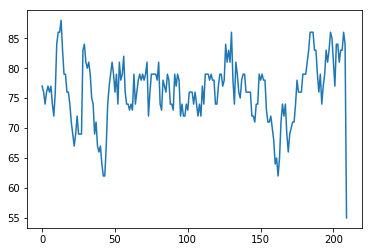

In [170]:
#Generate 200 notes
#model.load_weights('./hijacked_weights/hijacked-125.hdf5')
#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    prediction = model.predict(x.reshape(1,input_length,1))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note
plt.plot(predicted_notes)

In [102]:
#write to file
midi_functions.create_midi_from_notes(predicted_notes, 'generated_clementi_music-236.mid',on=250)

In [4]:
#Create a little evaluation set for normal prediction (integer classes)
validation_split=0.20
n_val = int(validation_split * n)

Y_true = np.array(list(np.argwhere(sorted_notes == y) for y in np.copy(Y_orig[-n_val:]))).reshape(n_val)
X_val = np.copy(X_orig[-n_val:]) / max_note
Y_pred = model.predict(X_val.reshape(n_val,input_length,1))

Y_pred = np.array(list(np.argmax(y) for y in Y_pred))

Confusion matrix, without normalization
[[ 0  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  1  2  0]
 [ 0  0  0 ...  0  0  0]]
Normalized confusion matrix
[[ nan  nan  nan ...  nan  nan  nan]
 [0.   0.4  0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.54 0.   0.  ]
 [0.   0.   0.   ... 0.1  0.2  0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


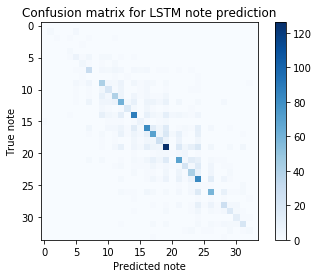

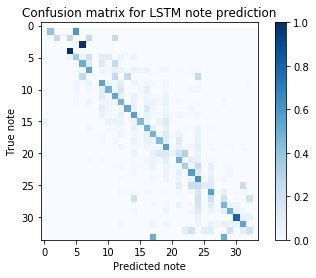

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           title=title,
           ylabel='True note',
           xlabel='Predicted note')

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred,
                      title='Confusion matrix for LSTM note prediction')
plt.savefig('CM_LSTM_unnormalized.pdf')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, normalize=True,
                      title='Confusion matrix for LSTM note prediction')
plt.savefig('CM_LSTM_normalized.pdf')
plt.show()


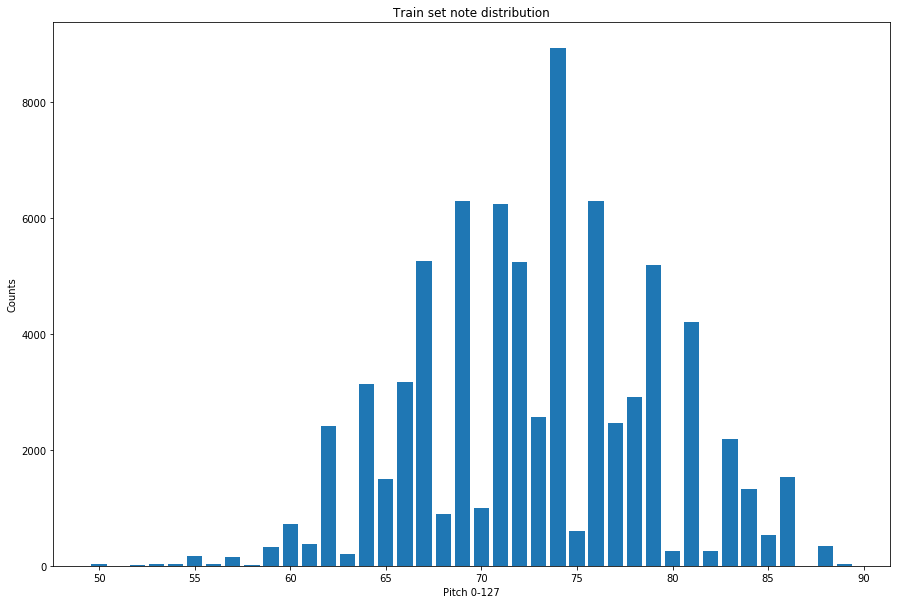

In [248]:
#Plots of note distribution
validation_split=0.20
n_train = int((1 - validation_split) * n)
X_train = X_orig[:n_train]
def prep_bar_plot(W):
    s = np.unique(W)
    counts = np.zeros(len(s))
    for i, note in enumerate(s):
        counts[i] = np.sum(W == note)
    return (s,counts)

s_notes, counts = prep_bar_plot(X_train)
plt.figure(figsize=(15,10))
plt.bar(s_notes, counts)
plt.ylabel('Counts')
plt.xlabel('Pitch 0-127')
plt.title('Train set note distribution')
plt.savefig('note_distribution.png')

In [219]:
#Create a little evaluation set for normal prediction
validation_split=0.20
n_val = int(validation_split * n)

Y_true = np.copy(Y_orig[-n_val:])
X_val = np.copy(X_orig[-n_val:]) / max_note
Y_pred = model.predict(X_val.reshape(n_val,input_length,1))

Y_pred = np.array(list(predicted_notes[np.argmax(y)] for y in Y_pred))

In [228]:
RMS = np.sqrt(np.mean(np.square(Y_pred - Y_true)))
RMS

9.537946558759508

In [9]:
#see what the ouput of softmax looks like compared to last note in input
x = X_val[np.random.randint(0,len(X_val))]
prediction = model.predict(x.reshape(1,input_length,1))
plt.plot(sorted_notes, prediction.reshape(n_notes_Y))
plt.axvline(x=x[9] * max_note)

NameError: name 'X_val' is not defined

In [240]:
#Distance from last note in sequence to next note
RMS = np.sqrt(np.mean(np.square(Y_orig - X_orig[:,input_length])))
RMS

3.7968132843473903

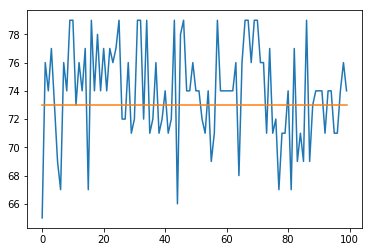

In [13]:
def generate_music_with_bias(bias):
    length = len(bias)
    init = X[np.random.randint(0,len(X))] #Picks out a random training example to begin generation

    predicted_notes = np.zeros(length + input_length)
    predicted_notes[0:input_length] = init
    #predicted_notes[9] = mean / max_note
    x = np.zeros(input_length)
    for note_index, note in enumerate(bias):
        x[0:input_length - 1] = predicted_notes[note_index:note_index + input_length - 1]
        x[input_length - 1] = note / max_note
        prediction = model.predict(x.reshape(1,input_length,1))
        predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
    
    return predicted_notes[input_length:] * max_note
    
bias = np.ones(100) * 73
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

In [19]:
def generate_music_with_bias(bias):
    length = len(bias)
    init = X[np.random.randint(0,len(X))] #Picks out a random training example to begin generation

    predicted_notes = np.zeros(length + input_length)
    predicted_notes[0:input_length] = init

    x = np.zeros(input_length)
    for note_index, note in enumerate(bias):
        x[0:input_length - 1] = predicted_notes[note_index:note_index + input_length - 1]
        x[input_length - 1] = note / max_note
        prediction = model.predict(x.reshape(1,input_length,1))
        predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
    
    return predicted_notes[input_length:] * max_note

In [6]:
#Generate music based on trajectory
top = 100
bot = 45
traj = np.loadtxt('traj/0000')
traj = traj[:,1]
max_traj = np.max(traj)
min_traj = np.min(traj)
traj = traj - min_traj
traj = traj / (max_traj - min_traj) * (top - bot)
traj += bot

In [12]:
#Place notes at certain intervals
traj_points_per_note = 5

points = np.arange(0,len(traj),traj_points_per_note)
new_traj = traj[points]

predicted_notes = generate_music_with_bias(new_traj)
plt.plot(predicted_notes)
plt.plot(new_traj)

AttributeError: module 'numpy' has no attribute 'zerros'

In [105]:
#write to file
midi_functions.create_midi_from_notes(predicted_notes,'clementi-236-traj0001.mid', on=250)

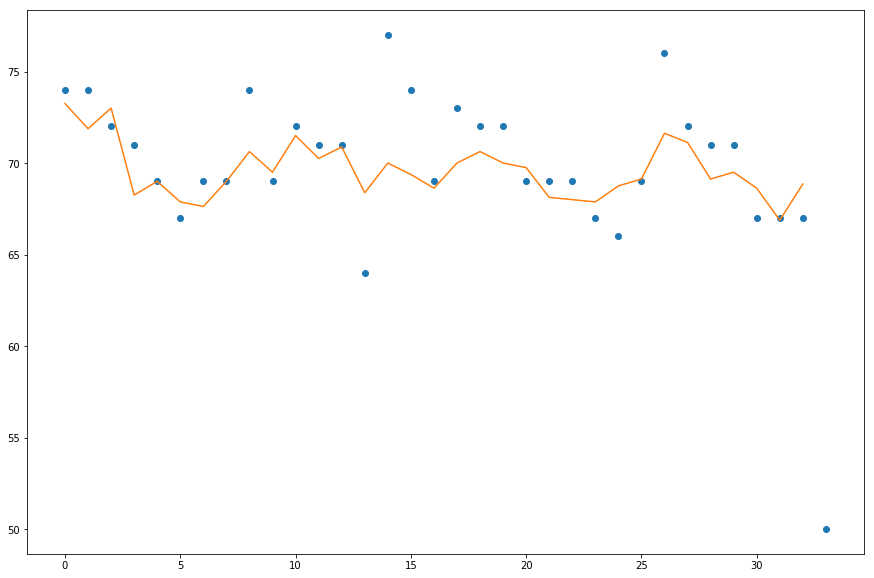

In [44]:
#The other option is to average the trajectory setps
traj_points_per_note = 8
new_traj = []
index = 0
while (index < len(traj)):
    new_traj.append(np.mean(traj[index:index + traj_points_per_note]))
    index += traj_points_per_note
new_traj.append(np.mean(traj[index:]))
new_traj = np.array(new_traj)

predicted_notes = generate_music_with_bias(new_traj)
plt.figure(figsize=(15,10))
plt.plot(predicted_notes[:],'o')
plt.plot(new_traj[:])

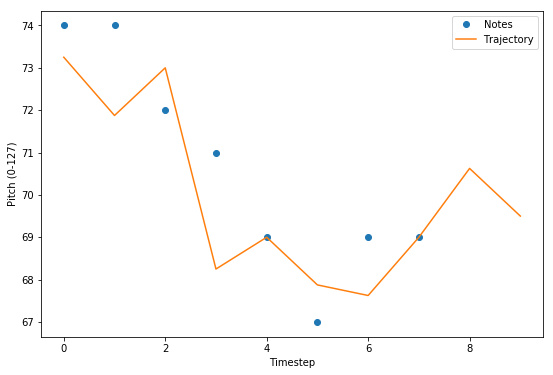

In [51]:
plt.figure(figsize=(9,6))
plt.plot(predicted_notes[:8],'o',label='Notes')
plt.plot(new_traj[0:10],label='Trajectory')
plt.ylabel('Pitch (0-127)')
plt.xlabel('Timestep')
plt.legend()

In [110]:
midi_functions.create_midi_from_notes(predicted_notes,'clementi-mean-236-traj0000.mid', on=250)

In [53]:
import glob
top = 100
bot = 45
def get_trajs():
    traj_files = glob.glob("./data/data/g*")
    trajs = []
    for index, file in enumerate(traj_files):
        traj = np.loadtxt(file)
        trajs.append(traj)
        #print(traj.shape)
    return trajs
trajs = get_trajs()
notes = []
for traj in trajs:
    notes.append(generate_music_with_bias(traj))

In [54]:
norm = 0
for traj, note in zip(trajs,notes):
       norm += np.linalg.norm(traj - note)
        
norm = norm / len(notes)

In [55]:
norm

60.899213487763035

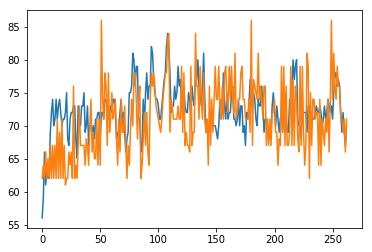

In [57]:
plt.plot(trajs[0])
plt.plot(notes[0])

In [56]:
len(trajs)

100